In [1]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#uncomment if using linux/macos
!rm -rf TrainSeg ValSeg
!mkdir TrainSeg ValSeg TrainSeg/Yes ValSeg/Yes

#uncomment if using windows
#!rmdir TrainSeg ValSeg /s /q
#!md TrainSeg ValSeg TrainSeg\Yes ValSeg\Yes


img_path = 'Dataset/'
train_list = []
val_list = []
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
for (n, file_name) in enumerate(files):
    img = os.path.join(img_path,CLASS,file_name)
    seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
    # 80% of images will be used for training, change the number here 
    # to use different number of images for training your model.
    if n < 0.8*img_num:
        shutil.copy(img, os.path.join('TrainSeg/',CLASS,file_name))
        train_list.append(os.path.join('TrainSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('TrainSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))
    else:
        shutil.copy(img, os.path.join('ValSeg/',CLASS,file_name))
        val_list.append(os.path.join('ValSeg/',CLASS,file_name))
        shutil.copy(seg, os.path.join('ValSeg/',CLASS,file_name.split('_')[0]+'_seg.npy'))

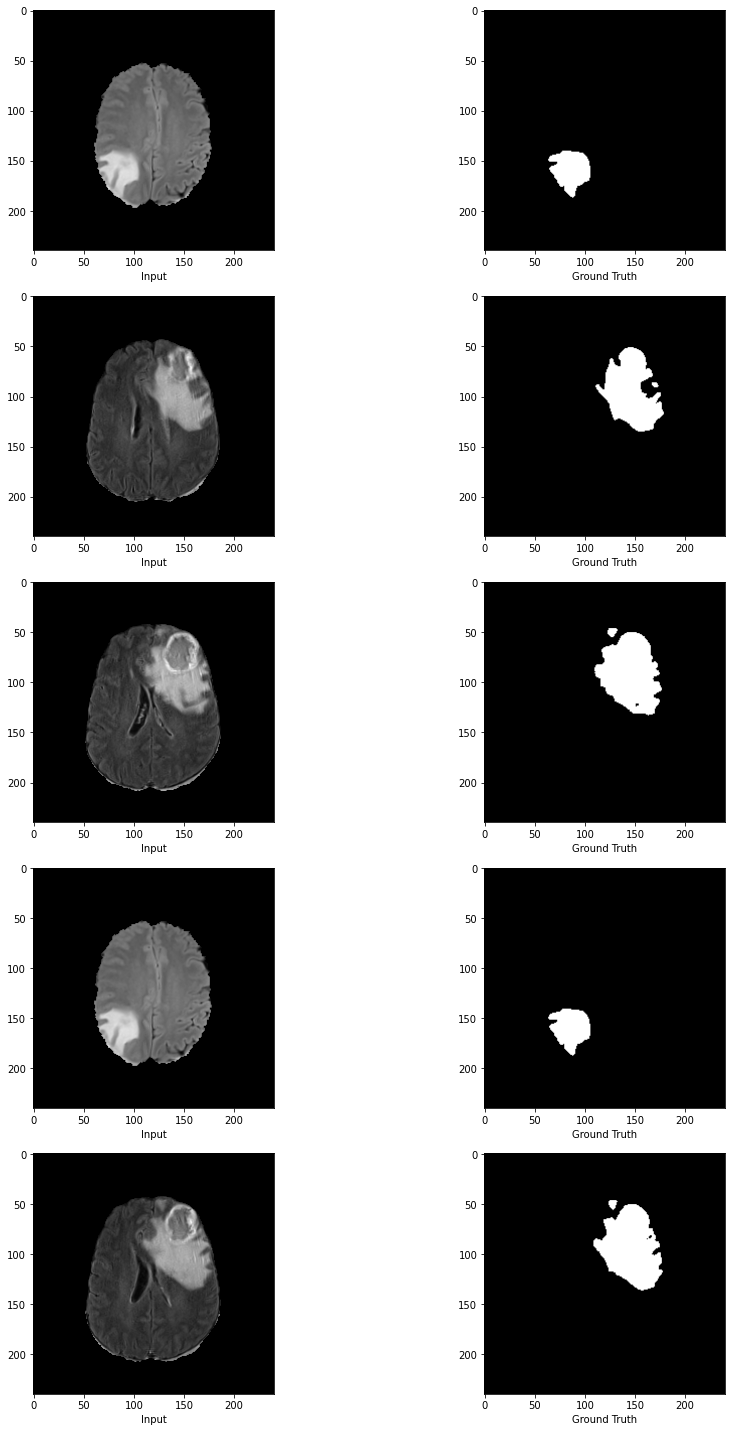

In [3]:
def plot_samples(x,n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            plt.imshow(np.load(x[idx])[:,:,0], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(np.load(x[idx].split('_')[0]+'_seg.npy')[:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()

plot_samples(train_list, n=5)

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=8, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store segmentation map
            y[i] = np.load(ID[:-8] +'_seg.npy')

        return X, y

In [5]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
IMG_SIZE = (240,240)
RANDOM_SEED = 100

In [6]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
def unet(input_size = (240,240,3),base_filter_num=64):
    inputs = Input(input_size)
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0_0 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
 
    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv1_0 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_0)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
 
    up1_0 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_0)
    merge00_10 = concatenate([conv0_0,up1_0], axis=-1)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge00_10)
    conv0_1 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_1)
 
    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv2_0 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
 
    up2_0 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_0)
    merge10_20 = concatenate([conv1_0,up2_0], axis=-1)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_20)
    conv1_1 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
 
    up1_1 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_1)
    merge01_11 = concatenate([conv0_0,conv0_1,up1_1], axis=-1)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge01_11)
    conv0_2 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_2)
 
    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv3_0 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_0)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
 
    up3_0 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_0)
    merge20_30 = concatenate([conv2_0,up3_0], axis=-1)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge20_30)
    conv2_1 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
 
    up2_1 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    merge11_21 = concatenate([conv1_0,conv1_1,up2_1], axis=-1)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11_21)
    conv1_2 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)
 
    up1_2 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_2)
    merge02_12 = concatenate([conv0_0,conv0_1,conv0_2,up1_2], axis=-1)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge02_12)
    conv0_3 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_3)
 
    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4_0 = Conv2D(base_filter_num*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_0)
 
    up4_0 = Conv2DTranspose(base_filter_num*8, (2, 2), strides=(2, 2), padding='same')(conv4_0)
    merge30_40 = concatenate([conv3_0,up4_0], axis = -1)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge30_40)
    conv3_1 = Conv2D(base_filter_num*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
 
    up3_1 = Conv2DTranspose(base_filter_num*4, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    merge21_31 = concatenate([conv2_0,conv2_1,up3_1], axis = -1)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge21_31)
    conv2_2 = Conv2D(base_filter_num*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)
 
    up2_2 = Conv2DTranspose(base_filter_num*2, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    merge12_22 = concatenate([conv1_0,conv1_1,conv1_2,up2_2], axis = -1)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12_22)
    conv1_3 = Conv2D(base_filter_num*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_3)
 
    up1_3 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_3)
    merge03_13 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up1_3], axis = -1)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)
    # 二分类任务
    conv0_4 = Conv2D(1, 1, activation = 'sigmoid')(conv0_4)
 
    model = Model(inputs = inputs, outputs = conv0_4)
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model

In [9]:
model = unet()
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=validation_generator,
)

TypeError: ('Keyword argument not understood:', 'input')

In [10]:
model.save('trained_seg_model.h5')

In [11]:
test_dir = 'ValSeg/'
#load your model here
dependencies = {
    'dice_score': dice_score
}
model = load_model('trained_seg_model.h5', custom_objects=dependencies)
test_list = []
CLASS = 'Yes'
all_files = os.listdir(test_dir + CLASS)
files = [item for item in all_files if "img" in item]
for file_name in files:
    test_list.append(test_dir + CLASS + '/' + file_name)        
test_generator = DataGenerator(test_list[:100], batch_size=1)

predictions = []
x_test = []
y_test = []
accuracy = []
for i in range(test_generator.__len__()):
    x, y = test_generator.__getitem__(i)
    x_test.append(x)
    y_test.append(y[0])
    prediction = model.predict(x)
    prediction[prediction>0.5] = 1
    prediction[prediction<=0.5] = 0
    predictions.append(prediction[0])
    accuracy.append(dice_score(y[0], prediction[0].astype('float64')))
print('Test Score = %.2f' % np.mean(accuracy))

Test Score = 0.01


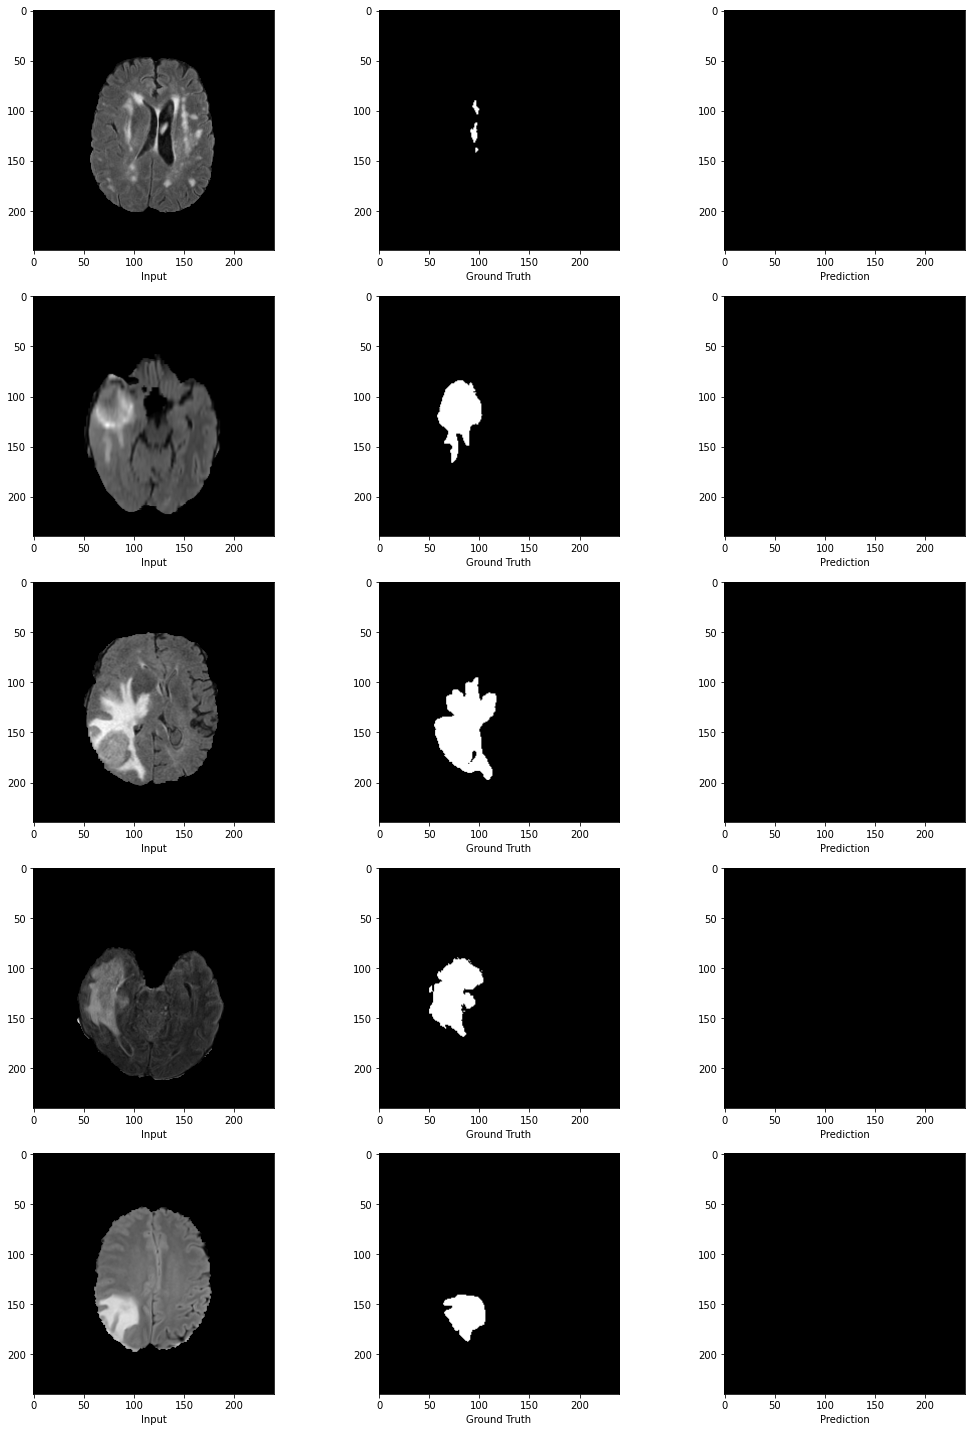

In [12]:
def plot_result(x,y,pred,n=10):
    i = n
    j = 3
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(x),size=n)
    for idx in idx_nums:
        while k%3 != 0: 
            plt.subplot(i,j,k)
            if k%3 == 1:
                plt.imshow(x[idx][0,:,:,0], cmap='gray')
                plt.xlabel("Input")
            if k%3 == 2:
                plt.imshow(y[idx][:,:], cmap='gray')
                plt.xlabel("Ground Truth")
            k += 1
        plt.subplot(i,j,k)
        plt.imshow(pred[idx][:,:,0], cmap='gray')
        plt.xlabel("Prediction")
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_result(x_test, y_test, predictions, n=5)